In [1]:
DATA_ID = 'mackey_glass_tau30_n200'   # dataset folder name

# Noise used in training & scoring
EVAL_SIGMA   = 0.20

# Ensure Sidekick angles stay within [0, π] even if we keep series-noise unclipped
SIDEKICK_CLIP_ANGLES = True

# Windowing / qubits (4q = 3 latent + 1 trash)
wind_size    = 4
wind_step    = 2
n_latent     = 2
n_trash      = wind_size - n_latent  # = 2

# Layers / instances
LAYER_OPTIONS     = [1,3]              # sidekick examples typically deeper; default 3
INSTANCE_IDS      = [1,2,3,4,5]  # seeds/instances

# Ansatz
ROTATION_KIND     = 'Rxyz'           # 'Ry' or 'Rxyz'

# Optimizer & epochs
S1_EPOCHS         = 200              # inverse-decoder (swap-test on clean)
S1_LR             = 0.10
S3_EPOCHS         = 300              # sidekick encoder (swap-test vs decoder latents)
S3_LR             = 0.01
WEIGHT_SCALER     = 0.05             # initial scale for trainable weights

# Device & differentiation switches
STAGE1_BACKEND    = 'lightning.qubit'   # 'default.qubit' or 'lightning.qubit'
STAGE3_BACKEND    = 'lightning.qubit'   # 'default.qubit' or 'lightning.qubit'
DIFF_METHOD_S1    = 'adjoint'           # 'adjoint' or 'best'
DIFF_METHOD_S3    = 'adjoint'           # 'adjoint' or 'best'
SHOTS             = None

# Random seeds base (we’ll derive per-instance)
TRAIN_SEED_BASE   = 88000
TEST_SEED_FIXED   = 99123

# Train/Test split on windows
split        = 0.75   # 75% windows → train, 25% → test

# Logging & paths
LOG_NAME     = 'aintern'
CASE_NAME    = 'sidekick'
DATA_PATH    = f'{LOG_NAME}/data'
FIGURES_PATH = f'{LOG_NAME}/figures'
TRAIN_PATH   = f'{LOG_NAME}/training'
PARAMS_PATH  = f'{LOG_NAME}/params'
ANALYSIS_PATH= f'{LOG_NAME}/analysis'
BUNDLE_ROOT  = 'qae_runs'

SAVE_PLOTS   = True

In [2]:
import os, sys, time, math, random, json, csv
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as pnp

# Repo utils
sys.path.append('.'); sys.path.append('..')
from qae_utils.Files import create_folder_if_needed, read_json_file, read_ts_file
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg, ts_add_noise
from qae_utils.Charts import multi_plot_flat_ts

# Folders
for p in [FIGURES_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, BUNDLE_ROOT]:
    create_folder_if_needed(p)

np.set_printoptions(suppress=True, precision=6)
plt.rcParams["figure.figsize"] = (6.5, 4)

def set_global_seed(instance_id: int):
    base = 10_000 + int(instance_id)
    random.seed(base + 11)
    np.random.seed(base + 22)
    try:
        pnp.random.seed(base + 33)
    except Exception:
        pass
    return dict(global_seed=base, numpy_seed=base+22, pnp_seed=base+33)

def ensure_dir(p: str | Path) -> Path:
    p = Path(p); p.mkdir(parents=True, exist_ok=True); return p

def arch_tag():
    # e.g., "4q_3l_1t"
    return f"{wind_size}q_{n_latent}l_{n_trash}t"

def choose_diff_method(requested: str):
    # We expose the switch but don’t silently override; circuits are unitary/prob readouts → adjoint OK on lightning.
    return requested

Using data folder: ../jacobs_examples/aintern/data/mackey_glass_tau30_n200
Loaded 200 samples; scale = [0.200, 0.800]


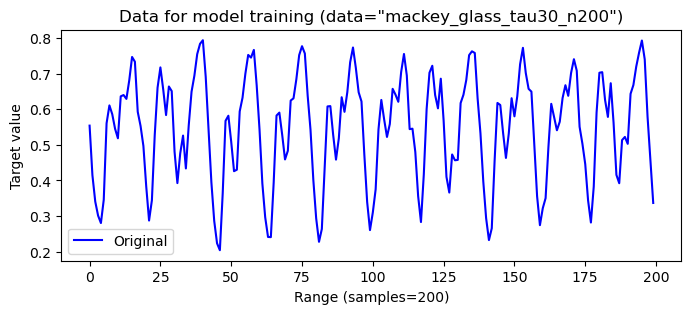

In [3]:
def _find_data_folder(data_id, log_name='aintern', preferred_root=None):
    candidates = []
    if preferred_root: candidates.append(preferred_root)
    candidates += [
        f'./{log_name}/data', f'../{log_name}/data', f'../../{log_name}/data',
        './jacobs_examples/aintern/data',
        '../jacobs_examples/aintern/data',
        '../../jacobs_examples/aintern/data',
    ]
    tried = []
    for root in candidates:
        folder = os.path.join(root, data_id)
        info_p = os.path.join(folder, 'info.json')
        x_p    = os.path.join(folder, 'x_org.arr')
        y_p    = os.path.join(folder, 'y_org.arr')
        tried.append(folder)
        if os.path.isdir(folder) and all(os.path.exists(p) for p in (info_p, x_p, y_p)):
            return folder
    raise FileNotFoundError("Could not find dataset folder.\n"
                            f"DATA_ID='{data_id}'. Tried:\n - " + "\n - ".join(tried))

DATA_FOLDER   = _find_data_folder(DATA_ID, log_name=LOG_NAME, preferred_root=DATA_PATH)
info          = read_json_file(f'{DATA_FOLDER}/info.json')
X             = read_ts_file(f'{DATA_FOLDER}/x_org.arr').astype(int)
y             = read_ts_file(f'{DATA_FOLDER}/y_org.arr')

scale_low  = float(info['scale_low'])
scale_high = float(info['scale_high'])

print(f'Using data folder: {DATA_FOLDER}')
print(f'Loaded {len(y)} samples; scale = [{scale_low:.3f}, {scale_high:.3f}]')

# Plot the clean series (reference)
multi_plot_flat_ts([y], X_list=[0], colors=['blue'], labels=['Original'],
                   lines=['solid'], legend_cols=1, rcParams=(8, 3),
                   xlabel=f'Range (samples={len(y)})',
                   title=f'Data for model training (data="{DATA_ID}")')

def values_to_angles(win_vals):
    """Map window values in [scale_low, scale_high] → angles in [0, π]."""
    v = pnp.array(win_vals, dtype=float)
    v01 = (v - scale_low) / max(scale_high - scale_low, 1e-12)
    if SIDEKICK_CLIP_ANGLES:
        v01 = pnp.clip(v01, 0.0, 1.0)  # keep angles in [0, π] even if series values wandered
    return v01 * pnp.pi

def expZ_to_values(z_all):
    z = pnp.clip(pnp.asarray(z_all), -0.999999, 0.999999)
    v01 = (z + 1.0) * 0.5
    return v01 * (scale_high - scale_low) + scale_low

In [4]:
def entangler_shape(n_layers, n_wires, rot='Ry'):
    if rot == 'Ry':
        return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    elif rot == 'Rxyz':
        return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    else:
        return ()

def entangler(weights, wires, rot='Ry'):
    if rot == 'Ry':
        qml.BasicEntanglerLayers(weights, wires=wires, rotation=qml.RY)
    elif rot == 'Rxyz':
        qml.StronglyEntanglingLayers(weights, wires=wires)

def sequence_encoder(wires, inputs):
    n_inputs = len(inputs)
    for i, w in enumerate(wires):
        theta = 0.0 if i >= n_inputs else inputs[i]
        qml.RY(theta, wires=w)

def swap_space(from_wires, to_wires):
    for f, t in zip(from_wires, to_wires):
        qml.SWAP(wires=[f, t])

def swap_test(from_wires, to_wires, ancilla_wire):
    qml.Hadamard(wires=ancilla_wire)
    for f, t in zip(from_wires, to_wires):
        qml.CSWAP(wires=[ancilla_wire, f, t])
    qml.Hadamard(wires=ancilla_wire)

def p1_from_expZ(z_vals):
    """Convert ⟨Z⟩ on ancilla → P(|1⟩)"""
    return (1.0 - pnp.asarray(z_vals)) * 0.5

In [5]:
S1_WIRES = n_latent + 2*n_trash + 1

def qae_inv_decoder_model(wires, n_latent, n_trash, n_layers=1, rot='Ry'):
    latent_wires = wires[0:n_latent]
    trash_wires  = wires[n_latent:n_latent+n_trash]
    zero_wires   = wires[n_latent+n_trash:n_latent+2*n_trash]
    anc          = wires[-1]
    data_wires   = latent_wires + trash_wires
    anz_wires    = data_wires

    def _qae_inv_decoder(weights, inputs_angles):
        sequence_encoder(data_wires, inputs_angles)
        entangler(weights, anz_wires, rot=rot)
        qml.Barrier(wires)
        swap_test(trash_wires, zero_wires, anc)
        qml.Barrier(wires)
        # RETURN ⟨Z⟩, not probs — adjoint-friendly
        return qml.expval(qml.PauliZ(wires=anc))
    return _qae_inv_decoder

def stage1_train_inverse_decoder(clean_windows_angles, n_layers, instance_id,
                                 rot=ROTATION_KIND, backend=STAGE1_BACKEND, diff_method=DIFF_METHOD_S1,
                                 n_epochs=S1_EPOCHS, lr=S1_LR, weight_scaler=WEIGHT_SCALER):
    set_global_seed(instance_id)

    shp = entangler_shape(n_layers, n_latent + n_trash, rot=rot)
    init_W = pnp.array(np.random.rand(*shp) * 2*np.pi * weight_scaler, requires_grad=True)

    dev = qml.device(backend, wires=list(range(S1_WIRES)), shots=SHOTS)
    diff = choose_diff_method(diff_method)
    model = qml.QNode(qae_inv_decoder_model(list(range(S1_WIRES)), n_latent, n_trash, n_layers, rot),
                      dev, interface="autograd", diff_method=diff)

    opt = qml.AdamOptimizer(stepsize=lr)
    hist_cost, hist_params = [], []

    t0 = time.perf_counter()
    W = init_W
    for ep in range(n_epochs):
        z_list = pnp.stack([model(W, values_to_angles(w)) for w in clean_windows_angles])  # ⟨Z⟩ per window
        cost   = pnp.mean(p1_from_expZ(z_list))  # average P(|1⟩)

        def _cost(p):
            z_b = pnp.stack([model(p, values_to_angles(w)) for w in clean_windows_angles])
            return pnp.mean(p1_from_expZ(z_b))

        W, _  = opt.step_and_cost(_cost, W)

        if ep % 1 == 0:
            hist_cost.append(float(cost)); hist_params.append(pnp.array(W, requires_grad=False))
        if ep % max(1, n_epochs//10) == 0:
            print(f"[S1] ep {ep:03d} | cost {float(cost):.6f}")
    t_s1 = time.perf_counter() - t0

    min_idx = int(np.argmin(hist_cost))
    best_W  = pnp.array(hist_params[min_idx], requires_grad=False)
    best_c  = float(hist_cost[min_idx])

    print(f"[S1] done: best {best_c:.6f} @ {min_idx} | time {t_s1:.1f}s")
    return dict(phi=best_W, best_train=best_c, hist_cost=hist_cost, time_s=t_s1,
                shape=tuple(shp), rot=str(rot), backend=str(backend), diff=str(diff))

In [6]:
S3_WIRES = 2*(n_latent + n_trash) + 1

def qae_sidekick_model(wires, dec_weights, n_latent, n_trash, n_layers=1, rot='Ry'):
    dec_lat = wires[0:n_latent]
    dec_tr  = wires[n_latent:n_latent+n_trash]
    enc_lat = wires[n_latent+n_trash:n_latent+n_trash+n_latent]
    enc_tr  = wires[n_latent+n_trash+n_latent:n_latent+n_trash+n_latent+n_trash]
    anc     = wires[-1]

    def _qae_sidekick(enc_weights, inputs_concat_angles):
        half = n_latent + n_trash
        dec_in = inputs_concat_angles[:half]
        enc_in = inputs_concat_angles[half:]

        sequence_encoder(dec_lat + dec_tr, dec_in)
        entangler(dec_weights, dec_lat + dec_tr, rot=rot)

        sequence_encoder(enc_lat + enc_tr, enc_in)
        entangler(enc_weights, enc_lat + enc_tr, rot=rot)

        qml.Barrier(wires)
        swap_test(dec_lat, enc_lat, anc)
        qml.Barrier(wires)
        # RETURN ⟨Z⟩ on ancilla — adjoint-friendly
        return qml.expval(qml.PauliZ(wires=anc))
    return _qae_sidekick

def stage3_train_sidekick(y_series, dec_weights, n_layers, instance_id,
                          rot=ROTATION_KIND, backend=STAGE3_BACKEND, diff_method=DIFF_METHOD_S3,
                          n_epochs=S3_EPOCHS, lr=S3_LR, weight_scaler=WEIGHT_SCALER,
                          train_seed_base=TRAIN_SEED_BASE, eval_sigma=EVAL_SIGMA):
    set_global_seed(instance_id)

    shp = entangler_shape(n_layers, n_latent + n_trash, rot=rot)
    init_enc = pnp.array(np.random.rand(*shp) * 2*np.pi * weight_scaler, requires_grad=True)

    dev = qml.device(backend, wires=list(range(S3_WIRES)), shots=SHOTS)
    diff = choose_diff_method(diff_method)
    model = qml.QNode(qae_sidekick_model(list(range(S3_WIRES)), pnp.array(dec_weights, requires_grad=False),
                                         n_latent, n_trash, n_layers, rot),
                      dev, interface="autograd", diff_method=diff)

    opt = qml.AdamOptimizer(stepsize=lr)
    hist_cost, hist_params = [], []

    clean_wins = ts_wind_make(y_series, wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(clean_wins))])
    _, tr_clean, _, _ = ts_wind_split(X_ts, clean_wins, split)

    t0 = time.perf_counter()
    enc_W = init_enc
    for ep in range(n_epochs):
        # epoch-specific noisy windows (NO CLIP in series; angles optionally clamped to [0,π])
        y_noisy = ts_add_noise(y_series, noise=eval_sigma, noise_type='normal', clip=False,
                               range_low=scale_low, range_high=scale_high, seed=train_seed_base + ep)
        noisy_wins = ts_wind_make(y_noisy, wind_size, wind_step)
        _, tr_noisy, _, _ = ts_wind_split(X_ts, noisy_wins, split)

        concat_inputs = [pnp.concatenate([values_to_angles(c), values_to_angles(n)]) for c, n in zip(tr_clean, tr_noisy)]

        z_list = pnp.stack([model(enc_W, ci) for ci in concat_inputs])  # ⟨Z⟩ on ancilla
        cost   = pnp.mean(p1_from_expZ(z_list))

        def _cost(p):
            zb = pnp.stack([model(p, ci) for ci in concat_inputs])
            return pnp.mean(p1_from_expZ(zb))

        enc_W, _ = opt.step_and_cost(_cost, enc_W)

        if ep % 1 == 0:
            hist_cost.append(float(cost)); hist_params.append(pnp.array(enc_W, requires_grad=False))
        if ep % max(1, n_epochs//10) == 0:
            print(f"[S3] ep {ep:03d} | cost {float(cost):.6f}")

    t_s3 = time.perf_counter() - t0
    min_idx = int(np.argmin(hist_cost))
    best_enc = pnp.array(hist_params[min_idx], requires_grad=False)
    best_c   = float(hist_cost[min_idx])

    print(f"[S3] done: best {best_c:.6f} @ {min_idx} | time {t_s3:.1f}s")
    return dict(psi=best_enc, best_train=best_c, hist_cost=hist_cost, time_s=t_s3,
                TEST_SEED_FIXED=int(TEST_SEED_FIXED),
                shape=tuple(shp), rot=str(rot), backend=str(backend), diff=str(diff))

In [7]:
# Full-QAE wires for inference:
#   data_wires = latent+trash      (size = n_latent + n_trash)
#   zero_wires = trash (|0...0|)   (size = n_trash)
#   total wires = n_latent + 2*n_trash
FQ_WIRES = n_latent + 2*n_trash

def qae_full_model(wires, enc_weights, dec_weights, n_latent, n_trash, n_layers, rot):
    lat = wires[0:n_latent]
    tr  = wires[n_latent:n_latent+n_trash]
    zro = wires[n_latent+n_trash:n_latent+2*n_trash]
    data = lat + tr

    def _qae_full(inputs_angles):
        # Encode noisy angles on data wires
        sequence_encoder(data, inputs_angles)
        # Encoder entangler (ψ)
        entangler(enc_weights, data, rot=rot)

        # Unit SWAP reset: move trash into zeros, leave |0> in trash wires
        qml.Barrier(wires)
        swap_space(tr, zro)
        qml.Barrier(wires)

        # Decoder = adjoint of encoder entangler (φ)
        qml.adjoint(entangler)(dec_weights, data, rot=rot)

        # X flip to correct adjoint sign conventions
        for w in data:
            qml.PauliX(wires=w)

        # Readout expZ on data wires
        return [qml.expval(qml.PauliZ(m)) for m in data]
    return _qae_full

def run_full_qae_on_windows(enc_W, dec_W, windows_vals, backend=STAGE3_BACKEND, rot=ROTATION_KIND):
    # infer number of layers from weight shape (works for StronglyEntanglingLayers etc.)
    if hasattr(enc_W, "shape") and len(np.array(enc_W).shape) == 3:
        n_layers_eval = int(np.array(enc_W).shape[0])
    else:
        n_layers_eval = 1

    # force plain numpy everywhere (break any autograd tracing)
    encW_np = np.array(enc_W, dtype=float)
    decW_np = np.array(dec_W, dtype=float)

    dev = qml.device(backend, wires=list(range(FQ_WIRES)), shots=None)
    model = qae_full_model(list(range(FQ_WIRES)), encW_np, decW_np,
                           n_latent, n_trash, n_layers=n_layers_eval, rot=rot)

    @qml.qnode(dev, interface="numpy", diff_method=None)
    def qnode(angles_np):
        return model(angles_np)

    outs = []
    for w in windows_vals:
        # make sure the angles are PLAIN numpy, not pnp
        ang = np.asarray(values_to_angles(w), dtype=float)
        outs.append(np.asarray(qnode(ang)))
    return np.stack(outs)

In [8]:
def windows_from_seed(y_vec, sigma, seed):
    """Generate clean/noisy windows for a fixed seed (no clip to match prior experiments)."""
    y_noisy = ts_add_noise(y_vec, noise=sigma, noise_type='normal', clip=False,
                           range_low=scale_low, range_high=scale_high, seed=seed)
    win_clean = ts_wind_make(y_vec,   wind_size, wind_step)
    win_noisy = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(win_clean))])
    _, tr_clean, _, te_clean = ts_wind_split(X_ts, win_clean, split)
    _, tr_noisy, _, te_noisy = ts_wind_split(X_ts, win_noisy, split)
    return np.asarray(tr_clean), np.asarray(tr_noisy), np.asarray(te_clean), np.asarray(te_noisy)

def flatten_avg(windows):
    return ts_wind_flatten_avg(np.asarray(windows), wind_step)

def mse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.mean((a - b)**2))

In [9]:
ALL_RUNS = []

for L in LAYER_OPTIONS:
    print(f"\n===== L={L} (rot={ROTATION_KIND}) =====")
    for inst in INSTANCE_IDS:
        print("\n" + "="*30)
        print(f"Instance {inst}")
        print("="*30)
        set_global_seed(inst)

        # ---- Clean windows once for Stage-1 training (angles created inside S1 call) ----
        clean_windows = ts_wind_make(y, wind_size, wind_step)
        X_ts = np.array([i*wind_step for i in range(len(clean_windows))])
        _, win_tr_clean, _, win_te_clean = ts_wind_split(X_ts, clean_windows, split)
        print(f"[Windows] train={len(win_tr_clean)}, test={len(win_te_clean)} (W={wind_size}, step={wind_step})")

        # ---- Stage 1: inverse decoder — TIMED ----
        t0_s1 = time.perf_counter()
        s1 = stage1_train_inverse_decoder(
            clean_windows_angles=win_tr_clean,
            n_layers=L, instance_id=inst,
            rot=ROTATION_KIND, backend=STAGE1_BACKEND, diff_method=DIFF_METHOD_S1,
            n_epochs=S1_EPOCHS, lr=S1_LR, weight_scaler=WEIGHT_SCALER
        )
        t_s1 = time.perf_counter() - t0_s1
        phi = s1["phi"]
        print(f"[Stage1] best train cost = {s1['best_train']:.6f} | time = {s1['time_s']:.1f}s (wall {t_s1:.1f}s)")

        # ---- Stage 3: sidekick encoder — TIMED ----
        t0_s3 = time.perf_counter()
        s3 = stage3_train_sidekick(
            y_series=y, dec_weights=phi, n_layers=L, instance_id=inst,
            rot=ROTATION_KIND, backend=STAGE3_BACKEND, diff_method=DIFF_METHOD_S3,
            n_epochs=S3_EPOCHS, lr=S3_LR, weight_scaler=WEIGHT_SCALER,
            train_seed_base=TRAIN_SEED_BASE, eval_sigma=EVAL_SIGMA
        )
        t_s3 = time.perf_counter() - t0_s3
        psi = s3["psi"]
        print(f"[Stage3] best train cost = {s3['best_train']:.6f} | time = {s3['time_s']:.1f}s (wall {t_s3:.1f}s)")

        # ---- Final fixed-seed scoring (like your other notebooks) ----
        seed_fix = s3.get("TEST_SEED_FIXED", TEST_SEED_FIXED)
        trC, trN, teC, teN = windows_from_seed(y, EVAL_SIGMA, seed_fix)

        # Reconstruct with full-QAE
        tr_pred_z = run_full_qae_on_windows(psi, phi, trN, backend=STAGE3_BACKEND)
        te_pred_z = run_full_qae_on_windows(psi, phi, teN, backend=STAGE3_BACKEND)

        # Convert expZ → original scale
        tr_pred = np.stack([np.asarray(expZ_to_values(zrow)) for zrow in tr_pred_z])
        te_pred = np.stack([np.asarray(expZ_to_values(zrow)) for zrow in te_pred_z])

        # Compute series-avg MSEs
        tr_pure = flatten_avg(trC);  te_pure = flatten_avg(teC)
        tr_noi  = flatten_avg(trN);  te_noi  = flatten_avg(teN)
        tr_hat  = flatten_avg(tr_pred); te_hat = flatten_avg(te_pred)

        mse_tr_noise = mse(tr_pure, tr_noi)
        mse_te_noise = mse(te_pure, te_noi)
        mse_tr_hat   = mse(tr_pure, tr_hat)
        mse_te_hat   = mse(te_pure, te_hat)

        d_tr = 100.0 * (1.0 - mse_tr_hat / max(mse_tr_noise, 1e-12))
        d_te = 100.0 * (1.0 - mse_te_hat / max(mse_te_noise, 1e-12))

        print(f"[Final TEST] MSE(series) TRAIN: noisy={mse_tr_noise:.6f} → rec={mse_tr_hat:.6f} Δ={d_tr:+.1f}%")
        print(f"[Final TEST] MSE(series) TEST : noisy={mse_te_noise:.6f} → rec={mse_te_hat:.6f} Δ={d_te:+.1f}%")

        ALL_RUNS.append(dict(
            instance_id=int(inst), n_layers=int(L),
            stage1=dict(best_train=s1["best_train"], phi=np.array(phi), time_s=float(s1["time_s"])),
            stage3=dict(best_train=s3["best_train"], psi=np.array(psi), time_s=float(s3["time_s"]),
                        TEST_SEED_FIXED=int(seed_fix)),
            metrics=dict(
                mse_tr_noise=float(mse_tr_noise), mse_te_noise=float(mse_te_noise),
                mse_tr_hat=float(mse_tr_hat), mse_te_hat=float(mse_te_hat),
                delta_tr_pct=float(d_tr), delta_te_pct=float(d_te)
            ),
            times=dict(
                s1_time_s=float(t_s1), s3_time_s=float(t_s3), total_time_s=float(t_s1 + t_s3)
            )
        ))

print("\nCompleted", len(ALL_RUNS), "runs.")


===== L=1 (rot=Rxyz) =====

Instance 1
[Windows] train=74, test=25 (W=4, step=2)
[S1] ep 000 | cost 0.405723
[S1] ep 020 | cost 0.218124
[S1] ep 040 | cost 0.187853
[S1] ep 060 | cost 0.182502
[S1] ep 080 | cost 0.181925
[S1] ep 100 | cost 0.181929
[S1] ep 120 | cost 0.181916
[S1] ep 140 | cost 0.181915
[S1] ep 160 | cost 0.181915
[S1] ep 180 | cost 0.181915
[S1] done: best 0.181915 @ 183 | time 79.1s
[Stage1] best train cost = 0.181915 | time = 79.1s (wall 79.2s)
[S3] ep 000 | cost 0.339313
[S3] ep 030 | cost 0.311306
[S3] ep 060 | cost 0.286233
[S3] ep 090 | cost 0.256908
[S3] ep 120 | cost 0.239990
[S3] ep 150 | cost 0.249796
[S3] ep 180 | cost 0.229755
[S3] ep 210 | cost 0.225182
[S3] ep 240 | cost 0.242905
[S3] ep 270 | cost 0.252165
[S3] done: best 0.220852 @ 259 | time 158.7s
[Stage3] best train cost = 0.220852 | time = 158.7s (wall 158.7s)
[Final TEST] MSE(series) TRAIN: noisy=0.019268 → rec=0.020610 Δ=-7.0%
[Final TEST] MSE(series) TEST : noisy=0.018958 → rec=0.017066 Δ=+10.0


=== Final plot for L=1, inst=1 ===
Saved plot → aintern/figures/final_sidekick/4q_2l_2t/L1/plot_4q_2l_2t_L1_inst01.png


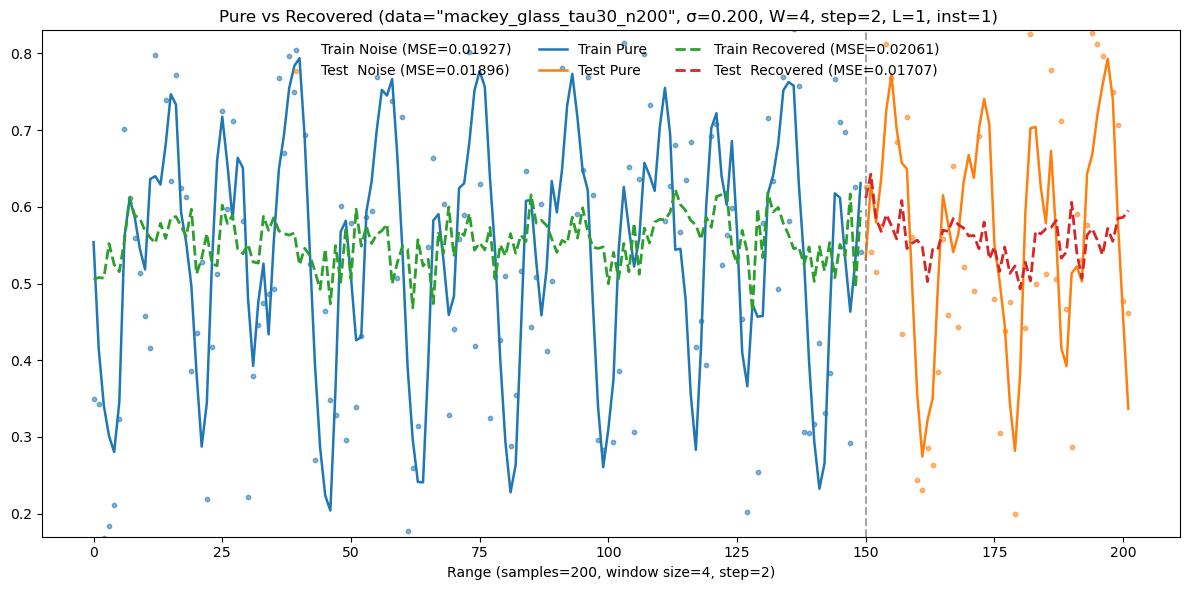


=== Final plot for L=1, inst=2 ===
Saved plot → aintern/figures/final_sidekick/4q_2l_2t/L1/plot_4q_2l_2t_L1_inst02.png


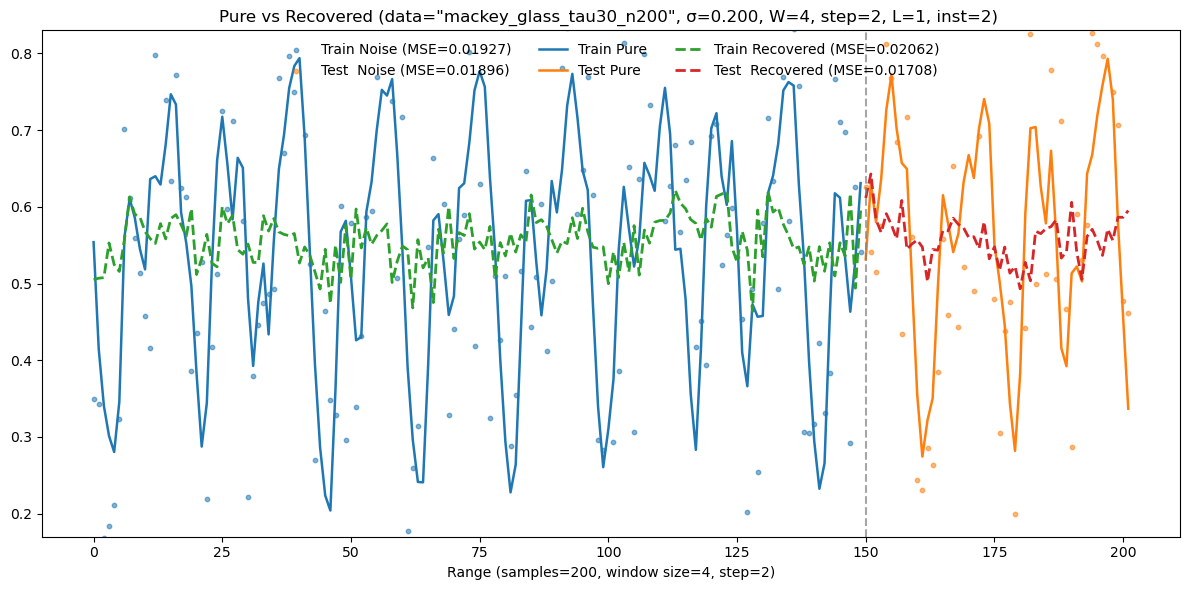


=== Final plot for L=1, inst=3 ===
Saved plot → aintern/figures/final_sidekick/4q_2l_2t/L1/plot_4q_2l_2t_L1_inst03.png


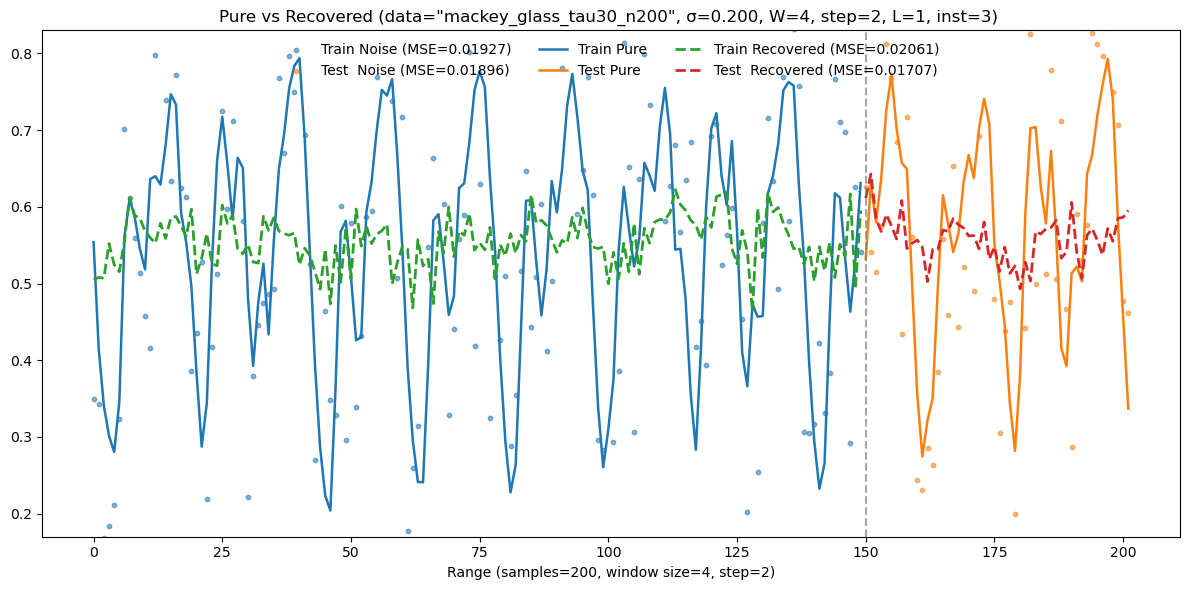


=== Final plot for L=1, inst=4 ===
Saved plot → aintern/figures/final_sidekick/4q_2l_2t/L1/plot_4q_2l_2t_L1_inst04.png


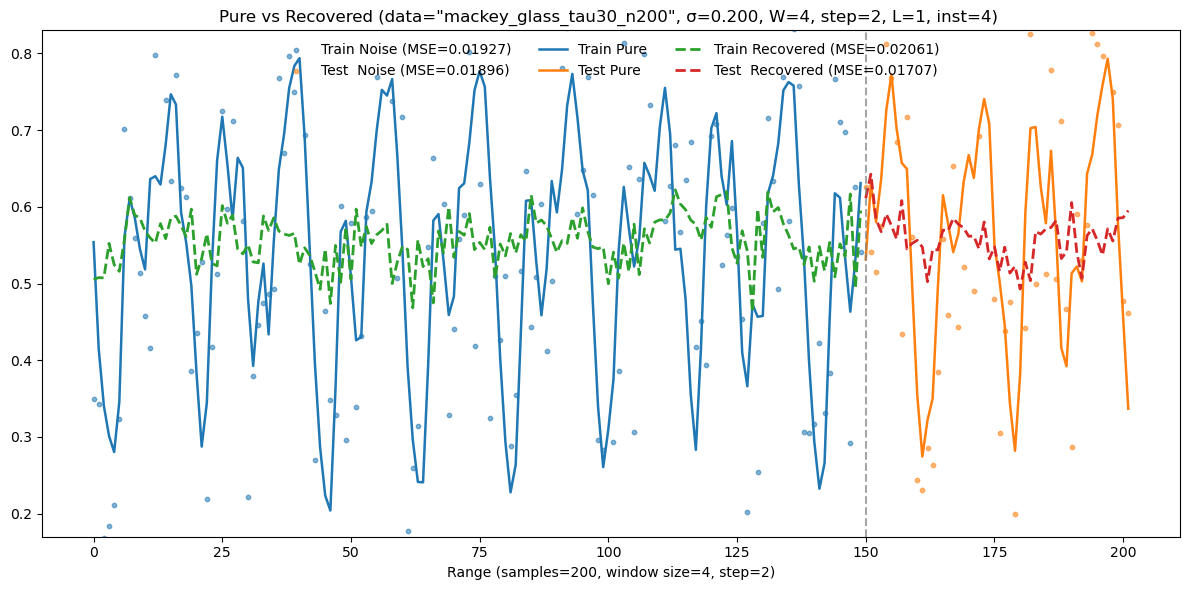


=== Final plot for L=1, inst=5 ===
Saved plot → aintern/figures/final_sidekick/4q_2l_2t/L1/plot_4q_2l_2t_L1_inst05.png


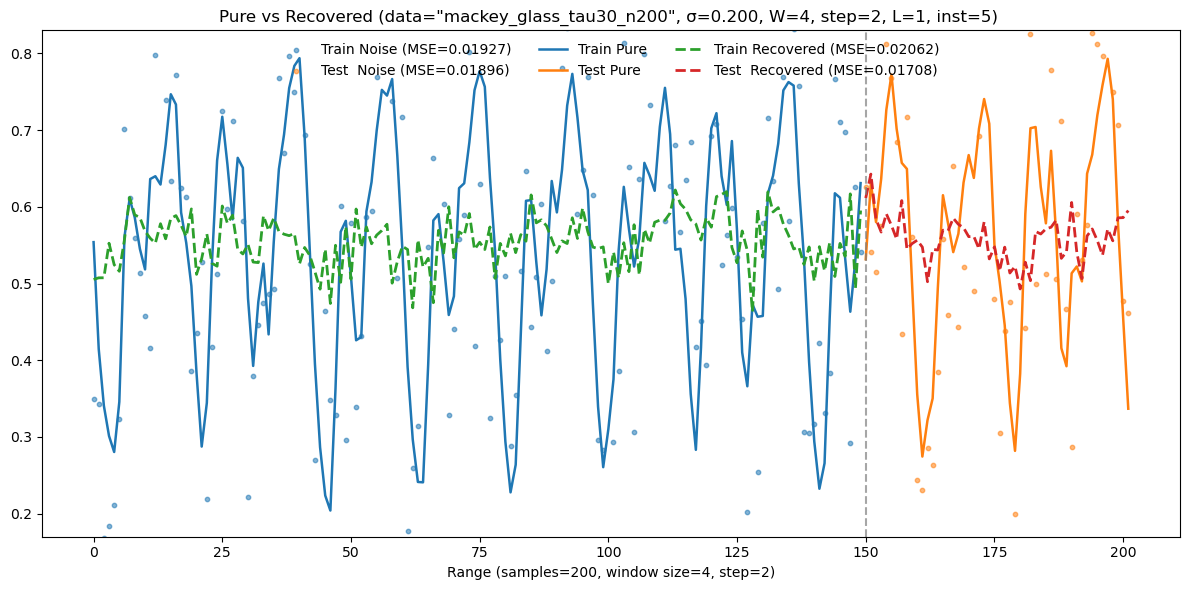


=== Final plot for L=3, inst=1 ===
Saved plot → aintern/figures/final_sidekick/4q_2l_2t/L3/plot_4q_2l_2t_L3_inst01.png


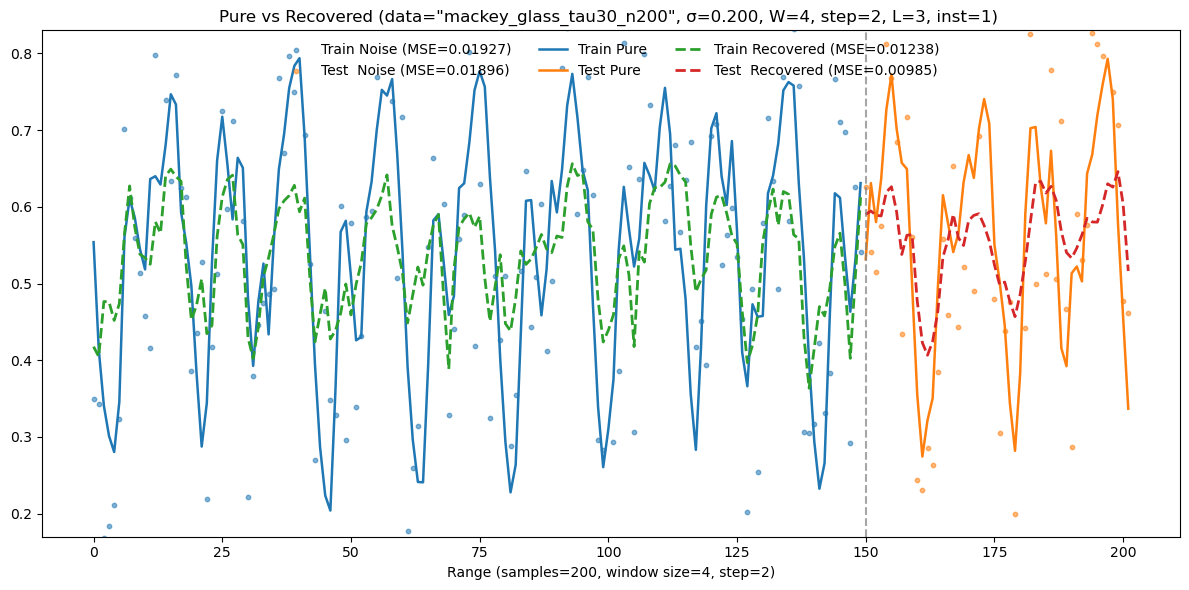


=== Final plot for L=3, inst=2 ===
Saved plot → aintern/figures/final_sidekick/4q_2l_2t/L3/plot_4q_2l_2t_L3_inst02.png


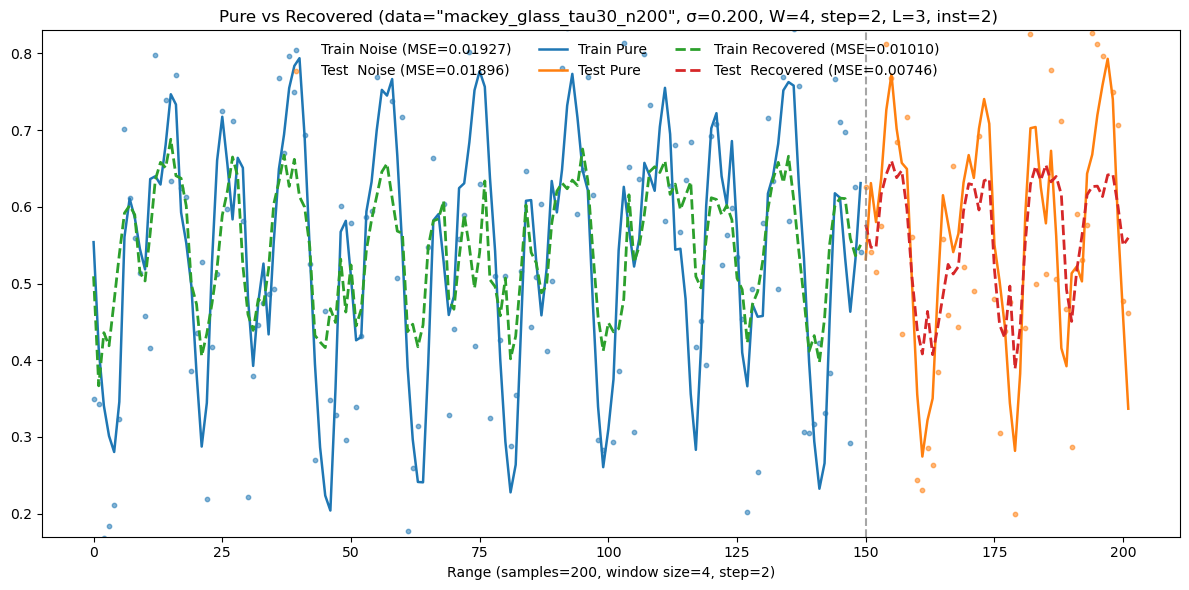


=== Final plot for L=3, inst=3 ===
Saved plot → aintern/figures/final_sidekick/4q_2l_2t/L3/plot_4q_2l_2t_L3_inst03.png


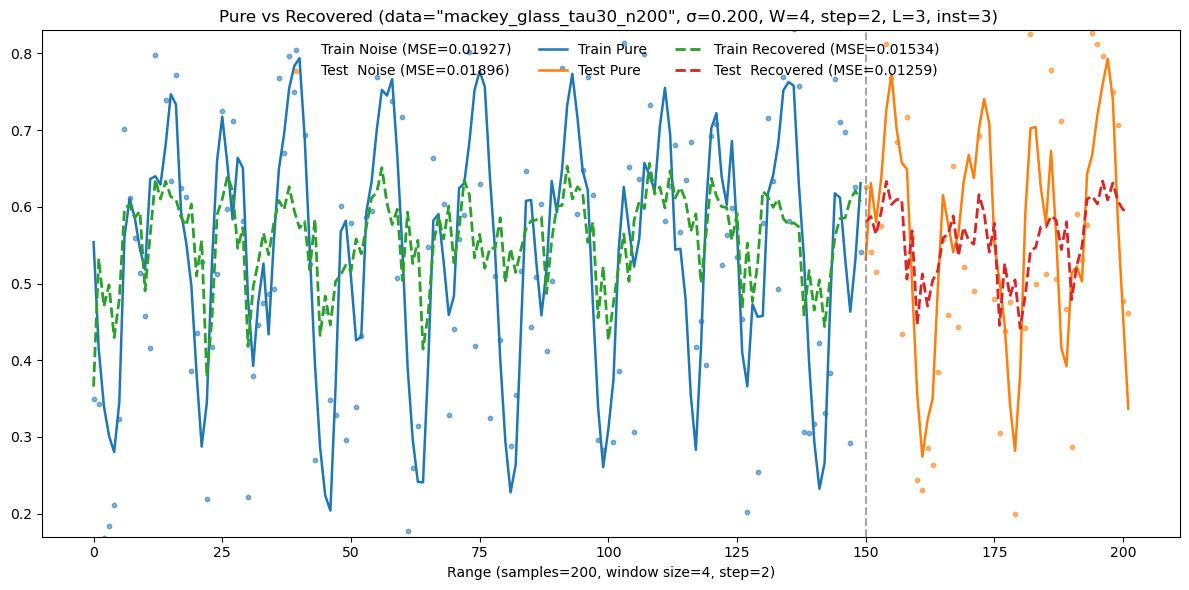


=== Final plot for L=3, inst=4 ===
Saved plot → aintern/figures/final_sidekick/4q_2l_2t/L3/plot_4q_2l_2t_L3_inst04.png


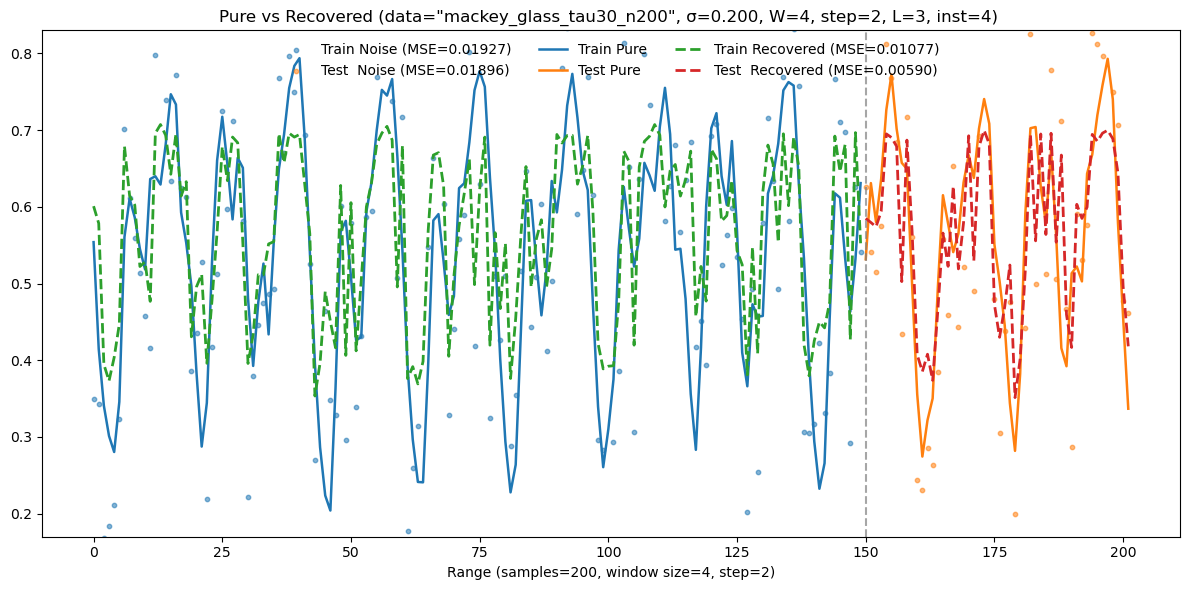


=== Final plot for L=3, inst=5 ===
Saved plot → aintern/figures/final_sidekick/4q_2l_2t/L3/plot_4q_2l_2t_L3_inst05.png


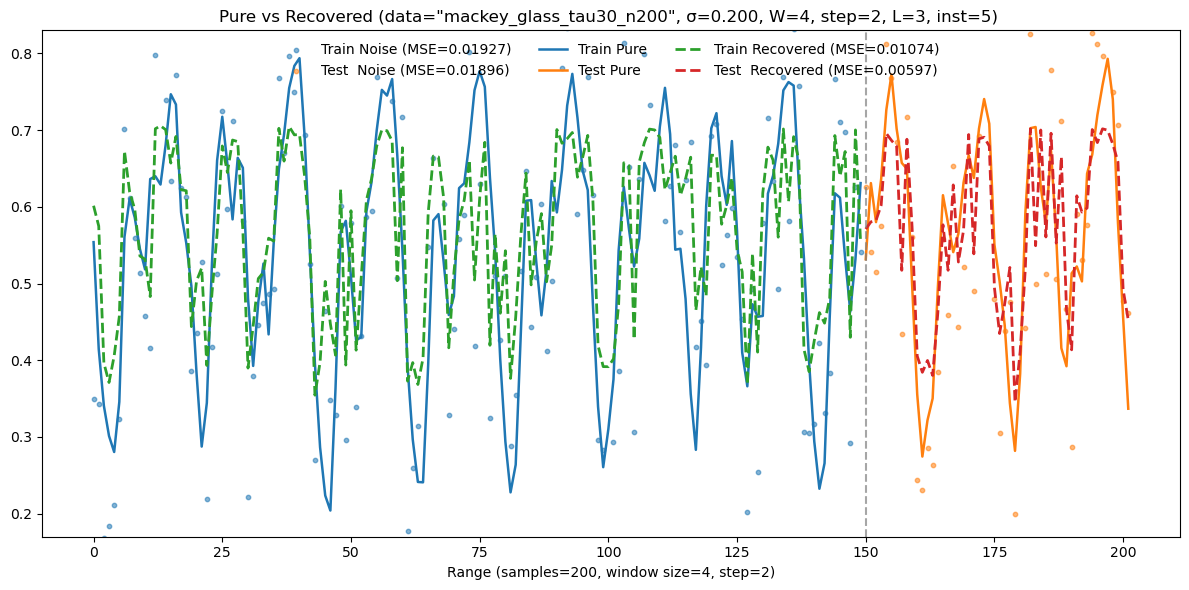

In [12]:
ARCH_TAG = arch_tag()

def plot_run(run, save_dir=None, title_note=""):
    inst = int(run["instance_id"])
    L    = int(run["n_layers"])
    phi  = np.array(run["stage1"]["phi"])
    psi  = np.array(run["stage3"]["psi"])

    seed = int(run["stage3"].get("TEST_SEED_FIXED", TEST_SEED_FIXED))

    trC, trN, teC, teN = windows_from_seed(y, EVAL_SIGMA, seed)
    tr_pred_z = run_full_qae_on_windows(psi, phi, trN, backend=STAGE3_BACKEND, rot=run["stage3"].get("rot", ROTATION_KIND))
    te_pred_z = run_full_qae_on_windows(psi, phi, teN, backend=STAGE3_BACKEND, rot=run["stage3"].get("rot", ROTATION_KIND))

    tr_pred = np.stack([np.asarray(expZ_to_values(zrow)) for zrow in tr_pred_z])
    te_pred = np.stack([np.asarray(expZ_to_values(zrow)) for zrow in te_pred_z])

    tr_pure = flatten_avg(trC);  te_pure = flatten_avg(teC)
    tr_noi  = flatten_avg(trN);  te_noi  = flatten_avg(teN)
    tr_hat  = flatten_avg(tr_pred); te_hat = flatten_avg(te_pred)

    mse_tr_noise = mse(tr_pure, tr_noi)
    mse_te_noise = mse(te_pure, te_noi)
    mse_tr_hat   = mse(tr_pure, tr_hat)
    mse_te_hat   = mse(te_pure, te_hat)

    x_tr = np.arange(len(tr_pure)); x_te = np.arange(len(tr_pure), len(tr_pure)+len(te_pure))
    x_split = len(tr_pure)

    plt.figure(figsize=(12, 6))
    plt.scatter(x_tr, tr_noi, s=10, alpha=0.55, label=f"Train Noise (MSE={mse_tr_noise:0.5f})")
    plt.scatter(x_te, te_noi, s=10, alpha=0.55, label=f"Test  Noise (MSE={mse_te_noise:0.5f})")
    plt.plot(x_tr, tr_pure, linewidth=1.8, label="Train Pure")
    plt.plot(x_te, te_pure, linewidth=1.8, label="Test Pure")
    plt.plot(x_tr, tr_hat, linestyle="--", linewidth=2.0, label=f"Train Recovered (MSE={mse_tr_hat:0.5f})")
    plt.plot(x_te, te_hat, linestyle="--", linewidth=2.0, label=f"Test  Recovered (MSE={mse_te_hat:0.5f})")
    plt.axvline(x_split, color="grey", linestyle="--", alpha=0.7)
    plt.ylim(scale_low - 0.05*(scale_high - scale_low), scale_high + 0.05*(scale_high - scale_low))
    plt.xlabel(f'Range (samples={len(y)}, window size={wind_size}, step={wind_step})')
    plt.title(f'Pure vs Recovered (data=\"{DATA_ID}\", σ={EVAL_SIGMA:.3f}, '
              f'W={wind_size}, step={wind_step}, L={L}, inst={inst}) {title_note}')
    plt.legend(loc="upper center", ncol=3, frameon=False)
    plt.tight_layout()

    if SAVE_PLOTS and save_dir:
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        out_png = Path(save_dir) / f"plot_{ARCH_TAG}_L{L}_inst{inst:02d}.png"
        plt.savefig(out_png, dpi=200, bbox_inches="tight", pad_inches=0.08)
        print(f"Saved plot → {out_png}")
    plt.show()

for L in LAYER_OPTIONS:
    for inst in INSTANCE_IDS:
        if any(r["n_layers"] == L and r["instance_id"] == inst for r in ALL_RUNS):
            run = next(r for r in ALL_RUNS if r["n_layers"] == L and r["instance_id"] == inst)
            print(f"\n=== Final plot for L={L}, inst={inst} ===")
            plot_run(run, save_dir=f"{FIGURES_PATH}/final_sidekick/{ARCH_TAG}/L{L}")

In [13]:
import pandas as pd

ROOT        = ensure_dir(BUNDLE_ROOT)
DATA_ROOT   = ensure_dir(ROOT / DATA_ID)
ARCH_ROOT   = ensure_dir(DATA_ROOT / ARCH_TAG)
dir_L       = {L: ensure_dir(ARCH_ROOT / f"L{int(L)}") for L in set(LAYER_OPTIONS)}

CSV_RUNS    = ARCH_ROOT / "metrics_by_run.csv"
CSV_SUMMARY = ARCH_ROOT / "summary_by_layer.csv"

RUNS_HEADER = [
    "dataset","arch","instance_id","layer",
    "window_size","step","sigma_eval",
    "mse_train_noise","mse_train_recovered","delta_train_pct",
    "mse_test_noise","mse_test_recovered","delta_test_pct",
    "s1_best_train_cost","s3_best_train_cost",
    "s1_time_s","s3_time_s","total_time_s",
    "timestamp","bundle_json"
]
if not CSV_RUNS.exists():
    with open(CSV_RUNS, "w", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow(RUNS_HEADER)

rows = []
for run in ALL_RUNS:
    inst = int(run["instance_id"])
    L    = int(run["n_layers"])
    phi  = np.array(run["stage1"]["phi"])
    psi  = np.array(run["stage3"]["psi"])

    # Save npy
    np.save(dir_L[L] / f"phi_inst{inst:02d}_L{L}.npy", phi)
    np.save(dir_L[L] / f"psi_inst{inst:02d}_L{L}.npy", psi)

    # Evaluate metrics already computed in ALL_RUNS
    m = run["metrics"]
    s_times = run["times"]

    # Build bundle
    bundle = {
        "schema": {"name": "sidekick_bundle", "version": "1.0"},
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "dataset": {
            "id": DATA_ID,
            "scale_low":  float(scale_low),
            "scale_high": float(scale_high),
            "window_size": int(wind_size),
            "window_step": int(wind_step),
            "split": float(split),
        },
        "run": {
            "instance_id": inst,
            "layer": L,
            "sigma_eval": float(EVAL_SIGMA),
            "test_seed_fixed": int(run["stage3"].get("TEST_SEED_FIXED", TEST_SEED_FIXED)),
        },
        "environment": {
            "stage1_backend": STAGE1_BACKEND,
            "stage1_diff": DIFF_METHOD_S1,
            "stage3_backend": STAGE3_BACKEND,
            "stage3_diff": DIFF_METHOD_S3,
        },
        "architecture": {
            "n_qubits": int(wind_size),
            "n_latent": int(n_latent),
            "n_trash":  int(n_trash),
            "rot": str(ROTATION_KIND),
        },
        "parameters": {
            "phi": phi.tolist(),  # decoder (inverse) weights
            "psi": psi.tolist(),  # encoder weights
        },
        "metrics_series": {
            "mse_train_noise": m["mse_tr_noise"],
            "mse_train_recovered": m["mse_tr_hat"],
            "delta_train_pct": m["delta_tr_pct"],
            "mse_test_noise": m["mse_te_noise"],
            "mse_test_recovered": m["mse_te_hat"],
            "delta_test_pct": m["delta_te_pct"],
        },
        "times_seconds": {
            "stage1": s_times["s1_time_s"],
            "stage3": s_times["s3_time_s"],
            "total":  s_times["total_time_s"],
        }
    }
    bundle_path = dir_L[L] / f"bundle_inst{inst:02d}_L{L}.json"
    with open(bundle_path, "w", encoding="utf-8") as f:
        json.dump(bundle, f, indent=2)

    rows.append([
        DATA_ID, ARCH_TAG, inst, L,
        int(wind_size), int(wind_step), float(EVAL_SIGMA),
        m["mse_tr_noise"], m["mse_tr_hat"], m["delta_tr_pct"],
        m["mse_te_noise"], m["mse_te_hat"], m["delta_te_pct"],
        float(run["stage1"]["best_train"]), float(run["stage3"]["best_train"]),
        s_times["s1_time_s"], s_times["s3_time_s"], s_times["total_time_s"],
        bundle["timestamp"], str(bundle_path)
    ])

# Upsert into CSV
if rows:
    df_new = pd.DataFrame(rows, columns=RUNS_HEADER)
    if CSV_RUNS.exists():
        df_old = pd.read_csv(CSV_RUNS)
        key_cols = ["dataset","arch","instance_id","layer"]
        df_old = df_old.drop_duplicates(subset=key_cols, keep="last")
        df_new = pd.concat([df_old, df_new], ignore_index=True)
        df_new = df_new.drop_duplicates(subset=key_cols, keep="last")
    df_new.to_csv(CSV_RUNS, index=False)
    print(f"Updated per-run metrics → {CSV_RUNS}")

# Tiny per-layer summary
if Path(CSV_RUNS).exists():
    df = pd.read_csv(CSV_RUNS)
    summary = (df
        .groupby("layer", as_index=True)
        .agg(
            runs=("instance_id","count"),
            mse_test_noise_mean=("mse_test_noise","mean"),
            mse_test_recovered_mean=("mse_test_recovered","mean"),
            delta_test_pct_mean=("delta_test_pct","mean"),
            s1_time_s_mean=("s1_time_s","mean"),
            s3_time_s_mean=("s3_time_s","mean"),
            total_time_s_mean=("total_time_s","mean"),
        )
    )
    summary.to_csv(CSV_SUMMARY)
    print(f"Saved per-layer summary → {CSV_SUMMARY}")

print(f"Artifacts saved under → {ARCH_ROOT}")

Updated per-run metrics → qae_runs/mackey_glass_tau30_n200/4q_2l_2t/metrics_by_run.csv
Saved per-layer summary → qae_runs/mackey_glass_tau30_n200/4q_2l_2t/summary_by_layer.csv
Artifacts saved under → qae_runs/mackey_glass_tau30_n200/4q_2l_2t
